In [6]:
# !pip install scikit-surprise

In [77]:
import pandas as pd

import surprise
from surprise import SVD
from surprise import Reader
from surprise import Dataset
from surprise import accuracy

from surprise.model_selection import train_test_split
from surprise.model_selection import LeaveOneOut
from surprise.model_selection import cross_validate
from surprise import KNNBaseline
from surprise import SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
ratings = pd.read_csv('cleaned_data/ratings.csv')
ratings.head()

,user,movie,rating
0,6040,858,4
1,6040,593,5
2,6040,2384,4
3,6040,1961,4
4,6040,2019,5


In [18]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['user', 'movie', 'rating']], reader)

In [ ]:
"""
Basic algorithms

NormalPredictor
NormalPredictor algorithm predicts a random rating based on the distribution of the training set, which is assumed to be normal. This is one of the most basic algorithms that do not do much work.

BaselineOnly
BaselineOnly algorithm predicts the baseline estimate for given user and item.

k-NN algorithms

KNNBasic
KNNBasic is a basic collaborative filtering algorithm.

KNNWithMeans
KNNWithMeans is basic collaborative filtering algorithm, taking into account the mean ratings of each user.

KNNWithZScore
KNNWithZScore is a basic collaborative filtering algorithm, taking into account the z-score normalization of each user.

KNNBaseline
KNNBaseline is a basic collaborative filtering algorithm taking into account a baseline rating.

Matrix Factorization-based algorithms

SVD
SVD algorithm is equivalent to Probabilistic Matrix Factorization

SVDpp
The SVDpp algorithm is an extension of SVD that takes into account implicit ratings.

NMF
NMF is a collaborative filtering algorithm based on Non-negative Matrix Factorization. It is very similar with SVD.

Slope One
SlopeOne is a straightforward implementation of the SlopeOne algorithm.

Co-clustering
Coclustering is a collaborative filtering algorithm based on co-clustering."""

In [ ]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse') 

In [32]:
print('Using ALS')
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
algo = BaselineOnly(bsl_options=bsl_options)
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)

Using ALS
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


{'test_rmse': array([0.91211439, 0.91036326, 0.91327461]),
 'fit_time': (1.4382100105285645, 1.6370940208435059, 1.6437299251556396),
 'test_time': (2.757873058319092, 2.6020867824554443, 1.963613748550415)}

In [35]:
#BaselineOnly algorithm - predicts the baseline estimate for given user and item
trainset, testset = train_test_split(data, test_size=0.25)
algo = BaselineOnly(bsl_options=bsl_options)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 0.9109


0.910871619028571

In [55]:
#SVD algorithm - equivalent to Probabilistic Matrix Factorization
trainset, testset = train_test_split(data, test_size=0.25)
algo = SVD()
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

RMSE: 0.8884


0.8884034837151038

In [ ]:
#SVDpp algorithm - extension of SVD that takes into account implicit ratings.
#takes too long to run!
trainset, testset = train_test_split(data, test_size=0.25)
algo = SVDpp()
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

In [56]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['user', 'movie', 'actual_rating', 'predicted_rating', 'details'])
df['num_of_movies_rated_by_given_user'] = df.user.apply(get_Iu)
df['num_users_who_rated_movie'] = df.movie.apply(get_Ui)
df['error'] = abs(df.predicted_rating - df.actual_rating)
best_predictions = df.sort_values(by='error')[:10]
worst_predictions = df.sort_values(by='error')[-10:]

In [57]:
best_predictions

,user,movie,actual_rating,predicted_rating,details,num_of_movies_rated_by_given_user,num_users_who_rated_movie,error
42879,1569,296,5.0,5.0,{'was_impossible': False},73,1396,0.0
122540,5851,1269,5.0,5.0,{'was_impossible': False},120,428,0.0
122556,5102,2762,5.0,5.0,{'was_impossible': False},46,1495,0.0
122577,1180,260,5.0,5.0,{'was_impossible': False},31,1895,0.0
122590,5412,858,5.0,5.0,{'was_impossible': False},163,1423,0.0
122612,5056,2571,5.0,5.0,{'was_impossible': False},145,1633,0.0
93176,5569,1035,5.0,5.0,{'was_impossible': False},191,540,0.0
45141,2124,2858,5.0,5.0,{'was_impossible': False},505,2155,0.0
16732,2928,923,5.0,5.0,{'was_impossible': False},317,682,0.0
122952,3343,1197,5.0,5.0,{'was_impossible': False},39,1435,0.0


In [58]:
worst_predictions

,user,movie,actual_rating,predicted_rating,details,num_of_movies_rated_by_given_user,num_users_who_rated_movie,error
154137,5878,1945,1.0,4.879777,{'was_impossible': False},247,316,3.879777
135120,3415,1200,1.0,4.901366,{'was_impossible': False},116,1116,3.901366
82277,1437,3307,1.0,4.921199,{'was_impossible': False},113,155,3.921199
45281,1680,175,1.0,4.999310,{'was_impossible': False},1394,125,3.999310
118396,4801,1374,1.0,5.000000,{'was_impossible': False},144,911,4.000000
107426,805,356,1.0,5.000000,{'was_impossible': False},58,1372,4.000000
111311,1069,2858,1.0,5.000000,{'was_impossible': False},472,2155,4.000000
21647,3590,2571,1.0,5.000000,{'was_impossible': False},315,1633,4.000000
35631,3844,1566,1.0,5.000000,{'was_impossible': False},100,280,4.000000
161772,3358,1947,1.0,5.000000,{'was_impossible': False},170,429,4.000000


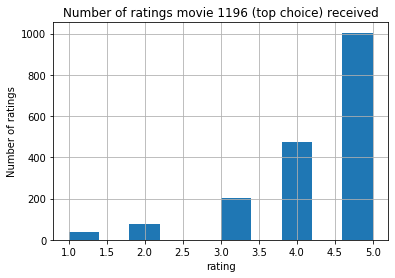

In [85]:
ratings.loc[ratings['movie'] == 296]['rating'].hist()
plt.xlabel('rating')
plt.ylabel('Number of ratings')
plt.title('Number of ratings movie 1196 (top choice) received')
plt.show();

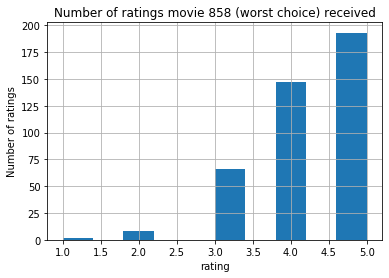

In [86]:
ratings.loc[ratings['movie'] == 1945]['rating'].hist()
plt.xlabel('rating')
plt.ylabel('Number of ratings')
plt.title('Number of ratings movie 858 (worst choice) received')
plt.show();